# Diffusion Entropy Analysis Demo

Garland Culbreth - Center for Nonlinear Science, University of North Texas.  

Written on 2020-08-22.

## About this notebook

This notebook is written as a step by step demonstration of the Diffusion Entropy Analysis method. Several publications describe the method, mostly in broad strokes and only with words, but none provide a step by step breakdown of what is happening with figures to illustrate. That is what I made this notebook to do.

This will probably be most useful to new students to the CNS, but collaborators or anyone else wishing to understand how the algorithm works may also find it helpful.

## Introduction

Diffusion Entropy Analysis (DEA) is a time-series analysis method for detecting temporal complexity in a dataset; such as particle motion, a seismograph, or an EEG signal. DEA converts the time-series into a diffusion trajectory, and uses the deviation of this diffusion from that of ordinary brownian motion as a measure of the temporal complexity in the data.  

This notebook uses the Modified DEA (or MDEA) formally set forth in \[Ref.1]. Meaning, it applies "stripes" to the time-series in question. "Stripes," in this case refer to regularly spaced lines or thresholds overlaid atop the time-series data, so that at every time index where the series crosses one of these "stripes", an event is recorded. (In the original, unmodified, DEA an event was recorded when the time-series changed sign \[Ref.2].)  

Thence, it follows the algorithm described in \[Ref.2] using the asymmetric diffusion method described in \[Ref.3]: The array of all positive events is summed (cumulative sum) to generate a diffusion trajectory based on the time-series. A window is moved along this trajectory and many small trajectories generated. Their displacements are binned (histogram) to create a probability density, which is then used to compute the Shannon entropy. Window length, $l$, is then increased, and the process repeated to get many values of the entropy, $S(l)$, one for each window length.  

The end goal is to plot $S(l)$ vs. $ln(l)$ and to use the relation between them to extract the scaling, $\delta$, of the time-series process.

## Getting started

First, naturally, do all the imports. My python implementation of DEA relies only on **NumPy** and **Matplotlib**. The **fbm** library provides some very useful ways to generate sample data for testing and benchmarking. **Pandas** is also useful, its DataFrames are very powerful (and you should use them). I also like to use **tqdm** for its progress bar showing runtime and completion, which is really nice. 

I also set the default plotting style to emulate ggplot. This is a personal preference and you can play with [other matplotlib styles](https://matplotlib.org/3.3.0/gallery/style_sheets/style_sheets_reference.html) to find your preference if you want.

In [271]:
import numpy as np
import matplotlib.pyplot as plt
from fbm import fbm, fgn
from tqdm import tqdm
import powerlaw

In [272]:
plt.style.use('ggplot')

## Sample data

Since this is a demo notebook, it needs data to demonstrate the algorithm on. I use a simple random walk. This is nice because it serves as a baseline for the method, showing you what DEA will give you for a totally random process. 

Use numpy to make an array of -1 or +1 randomly chosen, then takes the cumulative sum of that array to make those random steps into a random walk trajectory. Then output a figure of this random walk.

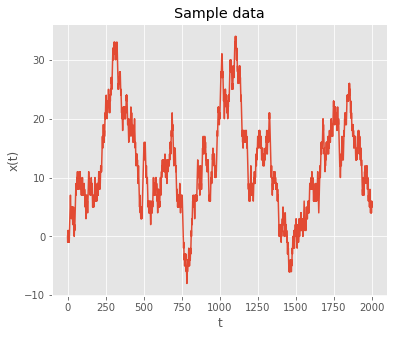

In [273]:
length = 2000
random_steps = np.random.choice([-1, 1], length)
random_steps[0] = 0  # always start from 0
random_walk = np.cumsum(random_steps)

plt.figure(figsize=(6, 5))
plt.plot(random_walk)
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Sample data')
plt.show()

## Stripes

The latest development to DEA is the addition of "stripes." This is the main subject of \[Ref.1]. To summarize: the time-series to be analysed is overlaid with a number of thresholds (hence "stripes"), and when the time-series crosses one of these an event is recorded at that time index.

In terms of code, the `apply_stripes()` function below takes the time-series, and rounds it to a number of 1-spaced thresholds. The number of these thresholds, or stripes, is a parameter defined by the user (you).
 - The number of stripes needs to be at least 2. If it's 1 or 0 the program will return nonsense, since it would be rounding to 1 threshold (which would flatten everything to a straight line) or 0 thresholds (which is impossible). 

In [274]:
def apply_stripes(data, stripes):
    """
    Rounds `data` to `stripes` evenly spaced intervals.

    Parameters
    ----------
    data : array_like
        Time-series data to be examined.
    stripes : int
        Number of stripes to apply. 

    Returns
    ----------
    rounded_data : ndarray
        data rounded to stripes number of equally spaced intervals.
    """
    max_data = max(data)
    min_data = min(data)
    data_width = abs(max_data - min_data)
    stripe_size = data_width / stripes
    rounded_data = []
    for i in range(len(data)):
        if data[i] >= 0:
            rounded_data.append(np.floor(data[i] / stripe_size))
        elif data[i] < 0:
            rounded_data.append(np.ceil(data[i] / stripe_size))
    return rounded_data, min_data, max_data

With that function defined, define a number of stripes to use and call the function to run on the random walk. Then make a plot of the original data with horizontal lines overlaid at the thresholds, and a plot of the rounded data, so you can see the effect.

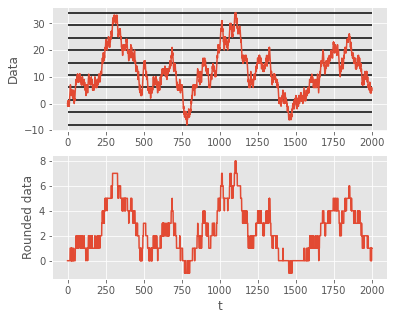

In [275]:
data = random_walk
number_of_stripes = 10

rounded_data = apply_stripes(data, number_of_stripes)

lines = np.linspace(rounded_data[1], rounded_data[2], num=number_of_stripes)
plt.figure(figsize=(6, 5))
plt.subplot(2,1,1)
plt.plot(data)
plt.hlines(y=lines, xmin=0, xmax=len(data))
plt.ylabel('Data')
plt.subplot(2,1,2)
plt.plot(rounded_data[0])
plt.xlabel('t')
plt.ylabel('Rounded data')
plt.show()

## Events

The reason for doing this rounding business is to make it easy to detect when the data crosses one of the stripes. DEA doesn't care about the amplitude of the data, only when it crosses one of the stripes. When it does, an **event** is recorded. In the DEA using stripes, these are represented by an array consisting of 1 at time indexes at which the data crossed a stripe, and 0 everywhere else. 

The rounding makes this very simple: Define an empty array, then step through the rounded data. Whenever the rounded data changes value, append a 1 to the event array. Whenever it does not, append a 0.

In [276]:
def find_events(series):
    """
    Records an event when `series` changes value. 

    Parameters
    ----------
    series : array_like
        Data series rounded to the stripe intervals.
    
    Returns
    ----------
    events : ndarray
        1 if event occured at that time index, 0 if not.
    """
    events = []
    for i in range(len(series)-1):
        if series[i] != series[i+1]:
            events.append(1)
        else:
            events.append(0)
    return events

So to illustrate, I feed `find_events()` the array of rounded data, and it returns an array of 0s and 1s telling what time indexes saw events occur. 

I plot the rounded data and the event array directly below it, so you can see the events coinciding with the time indexes that the rounded data changed value. 
 - Using a short, e.g. length = 100, random walk can make this even easier to see. 

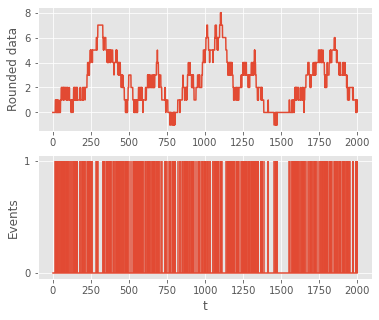

In [277]:
events = find_events(rounded_data[0])

plt.figure(figsize=(6, 5))
plt.subplot(2,1,1)
plt.plot(rounded_data[0])
plt.ylabel('Rounded data')
plt.subplot(2,1,2)
plt.stem(events, markerfmt="none", basefmt="C0-", use_line_collection=True)
plt.xlabel("t")
plt.yticks([0, 1])
plt.ylabel('Events')
plt.show()

## Diffusion trajectory

The next step is to construct a diffusion trajectory from the recorded events. This is extremely simple: just take the cumulative sum of the event array. 

In [278]:
def make_trajectory(events):
    """Constructs diffusion trajectory from events."""
    trajectory = np.cumsum(events)
    return trajectory

To illustrate this step, feed `make_trajectory()` the event array. Then plot the event array and the constructed diffusion trajectory right below it, you can see the trajectory increasing when there's events and plateauing when there's none.
 - Again, using a very short random walk makes this easier to see. 

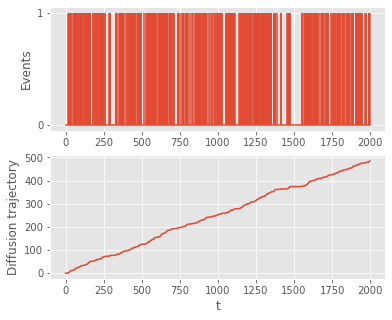

In [279]:
diffusion_trajectory = make_trajectory(events)

plt.figure(figsize=(6, 5))
plt.subplot(2,1,1)
plt.stem(events, markerfmt="none", basefmt="C0-", use_line_collection=True)
plt.yticks([0, 1])
plt.ylabel('Events')
plt.subplot(2,1,2)
plt.plot(diffusion_trajectory)
plt.xlabel('t')
plt.ylabel('Diffusion trajectory')
plt.show()

## Moving window

DEA uses a moving window to examine this diffusion trajectory. The idea is similar to some other time-series analysis methods which use moving windows.  
 - In particular, the moving window is used similarly to Detrended Fluctuation Analysis (DFA). The
 difference is that DFA  uses windows that do not overlap, while DEA uses window positions advancing one
 time index by one, with much overlap. This similarity and the rationale behind this decision is discussed
 in \[Ref.3].  

For demonstration only one window length is defined, which is then placed at fixed positions (end to end) on the diffusion trajectory. This makes the windows and snapshots easier to visualize. In practice you'd take a whole set of window lengths and step each one down the trajectory, shifting one index at a time. For this demonstration, I took only one possible window length, and a subset of the window positions.  

The `demo_snapshots()` function generates the set of window lengths.

In [280]:
def demo_snapshots(trajectory, window_length):
    slices = np.arange(0, len(trajectory)+2, window_length)
    return trajectory, slices

So, set an example window length to use and call that function to run on the sample diffusion trajectory.

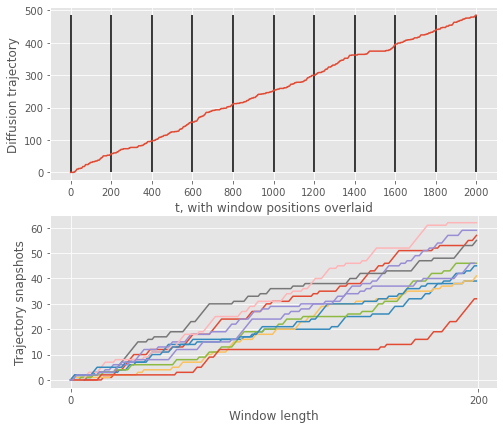

In [281]:
window_length = 200
trajectory, slices = demo_snapshots(diffusion_trajectory, window_length)

plt.figure(figsize=(8, 7))
plt.subplot(2,1,1)
plt.plot(trajectory)
plt.vlines(slices, ymin=0, ymax=max(trajectory))
plt.xticks(slices)
plt.xlabel('t, with window positions overlaid')
plt.ylabel('Diffusion trajectory')
plt.subplot(2,1,2)
for i in range(len(slices)-1):
    plt.plot(trajectory[slices[i]:slices[i+1]] - trajectory[slices[i]])
plt.xticks(ticks=slices[0:2])
plt.xlabel('Window length')
plt.ylabel('Trajectory snapshots')
plt.show()

This plot is important, so I'll break it down with more detail than the earlier ones:
 - The top subplot is the diffusion trajectory with vertical lines overlaid to show the chosen window positions. 
 - The bottom subplot are the slices (snapshots) of the diffusion trajectory over the window length and positions in the top figure, but drawn on top of each other such that they all start from the same origin.

## Probability density

The goal of all that window moving is to make a histogram of the displacements of each of those snapshots. This histogram forms the probability density, $P$, which will be needed to compute the entropy. 

Getting the histogram is simple enough: Take the displacements of all the snapshots:

In [282]:
def get_displacements(trajectory, L):
    displacements = []
    for i in range(len(trajectory)-L):
        displacements.append(trajectory[i+L] - trajectory[i])
    return displacements

and bin them in a matplotlib density histogram:

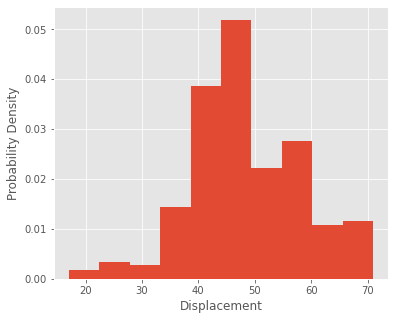

In [283]:
displacement = get_displacements(trajectory, window_length)

plt.figure(figsize=(6, 5))
plt.hist(displacement, density=True)
plt.xlabel('Displacement')
plt.ylabel('Probability Density')
plt.show()

## Entropy

The next step is to compute the Shannon entropy, $S$, of this probability distribution, $P$. This is done according to the relation:

$$ S(l) = - \sum P(l) ln(P(l)). $$  

At this point, it stops being convenient to restrict the demonstration to only the one window length and small set of positions. That would give you an $S$ just fine, but only one. We want one for each window length, and to use many window lengths. 

For a collection of window lengths, $l_i$, each stepped along the diffusion trajectory and the slice displacements binned as above to get the corresponding probability densities, $P(l_i)$, the corresponding Shannon entropies are given by:

$$ S_i(l) = - \sum_i P(l_i) ln(P(l_i)). $$  

The next cell contains the full function used by the DEA program to perform these calculations fast for many window lengths and positions.

In [284]:
def entropy(trajectory):
    """
    Calculates the Shannon Entropy of the diffusion trajectory.

    Generates a range of window lengths L. Steps each one along 
    `trajectory` and computes the displacement of `trajectory` 
    over each window position. Bins these displacements, and divides 
    by the sum of all bins to make the probability distribution `p`. 
    Puts `p` into the equation for Shannon Entropy to get s(L).
    Repeats for all L in range `WindowLengths`.

    Parameters
    ----------
    trajectory : array_like
        Diffusion trajectory. Constructed by make_trajectory.

    Returns
    ----------
    s : ndarray
        Shannon Entropy values, S(L).
    window_lengths : ndarray
        Window lengths, L. 

    Notes
    ----------
    `tqdm()` makes the progress bar appear.
    """
    s = []
    window_lengths = np.arange(1, int(0.25*len(trajectory)), 1)
    for L in tqdm(window_lengths):
        window_starts = np.arange(0, len(trajectory)-L, 1)
        window_ends = np.arange(L, len(trajectory), 1)
        displacements = trajectory[window_ends] - trajectory[window_starts]
        bin_counts = np.bincount(displacements)
        bin_counts = bin_counts[bin_counts != 0]
        p = bin_counts / np.sum(bin_counts)
        s.append(-np.sum(p * np.log(p)))
    return s, window_lengths

To illustrate, feed the diffusion trajectory into the function `entropy()`. This does all the steps described in the step by step breakdown, but many many times. Many window lengths, many positions, and yielding many values of the entropy $S(l)$, as seen in the plot it makes.

100%|██████████| 498/498 [00:00<00:00, 19941.60it/s]


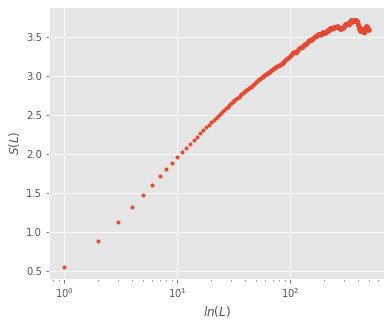

In [285]:
s, L = entropy(diffusion_trajectory)

plt.figure(figsize = (6, 5))
plt.plot(L, s, linestyle='', marker='.')
plt.xscale('log')
plt.xlabel('$ln(L)$')
plt.ylabel('$S(L)$')
plt.show()

At this point, all that remains is to extract the **scaling** from this figure. 

## Scaling

The relation between these entropies, $S(l)$ and the windows lengths, $l$, is given by:

$$ S(l) = \delta ln(l) + C, $$  

where $\delta$ is the **scaling** of the time-series and $C$ is some constant \[Ref.2]. This relation is linear in log-scale. So, if $S(l)$ is plotted against $ln(l)$, the slope is the scaling, $\delta$. 

To determine what the scaling is then, do a linear fit over $S(l)$ and $ln(l)$. That is what the next function `get_scaling()` does.

In practice, as the window lengths, $l$, start to get large compared to the total length of the diffusion trajectory, the entropies, $S(l)$, start to fluctuate wildly and fall off. This means that doing the fit over the entire array of $S(l)$ wouldn't give a good estimate for the scaling. Therefore, the user (you) also defines a `start` and `stop` index over which to perform the fit. The idea is to look at the plot for $S(l)$, see where there's a nice linear portion and where $S(l)$ starts to fall off, and adjust the `start` and `stop` so that the fitting lines up with the linear portion. This gives the best estimate for the scaling, $\delta$.

In [286]:
def get_scaling(s, L, start, stop):
    """
    Calculates scaling.
    
    Calculates the scaling of the time-series by performing a 
    least-squares linear fit over S(l) and ln(l).

    Parameters
    ----------
    s : array_like
        Shannon Entropy values. 
    L : array_like
        Window Lengths. 
    start : int
        Index at which to start the fit slice.
    stop : int
        Index at which to stop the fit slice.

    Returns
    ----------
    fit_slice_L : ndarray 
        The slice of window lengths L.
    coefficients : ndarray
        Slope and intercept of the fit. 

    Notes
    ----------
    Least-squares linear fits on log scale data have issues, 
    see doi:10.1371/journal.pone.0085777
    Making a version that uses the `powerlaw` package instead 
    would be better...
    """
    s_slice = s[start:stop]
    L_slice = L[start:stop]
    coefficients = np.polyfit(np.log(L_slice), s_slice, 1)
    return L_slice, coefficients

## $\mu$  

While DEA directly measures the scaling of the time-series process, it is most useful for measuring the temporal complexity in the time-series, which is expressed by the parameter $\mu$. This parameter is the power index of the powerlaw waiting-time distribution of the events. Denoting waiting-time between two events as $\tau$, the waiting-time distribution goes as $1/\tau^\mu$ \[Ref.2,3].

There are two relations connecting $\delta$ and $\mu$, depending on what range $\mu$ lies in:  
 - For $1 < \mu \le 2$: $ \mu = 1 + \delta. $  

 - For $2 \le \mu < 3$: $ \mu = 1 + 1/\delta. $  

The theoretical justifications for and explanations of these are given in § 3.2 of \[Ref.1] and § 3.1-3.2 of \[Ref.3]. The method of determining which calculation is the right one to use is given in **Interpreting results** below.

When $\mu > 3$, DEA gives $\delta = 0.5$ everywhere, so there is no useful information. 

In [287]:
def get_mu(delta):
    """
    Calculates the mu.

    Parameters
    ----------
    delta : float
        Scaling of the time-series process. 

    Returns
    ----------
    mu : float
        Complexity parameter. Powerlaw index for inter-event 
        time distribution.
    """
    mu = 1 + (1 / delta)
    if mu > 3:
        mu = 1 + delta
    return mu

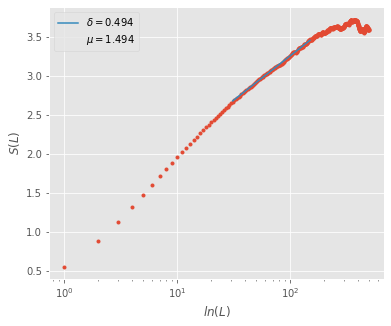

In [288]:
fit_start = 30
fit_stop = 150

fit = get_scaling(s, L, fit_start, fit_stop)
mu = get_mu(fit[1][0])

plt.figure(figsize = (6, 5))
plt.plot(L, s, linestyle='', marker='.')
plt.plot(fit[0], fit[1][0] * np.log(fit[0]) + fit[1][1],
         label='$\delta = {}$'.format(np.round(fit[1][0], 3)))
plt.plot([], [], linestyle='',
         label='$\mu = {}$'.format(np.round(mu, 3)))
plt.xscale('log')
plt.xlabel('$ln(L)$')
plt.ylabel('$S(L)$')
plt.legend(loc=0)
plt.show()

This is the final result. The plot of $S(l)$ vs. $ln(l)$, with the fit overlaid, labeled with the scaling $\delta$ and complexity parameter $\mu$.

## Interpreting Results  

### Basics  
 - $\delta$ is the measured scaling of the time-series process.  
 - $\mu$ is a complexity index, defined as the power for the inter-event time distribution $1/\tau^{\mu}$ ($\tau$ being inter-event time).  

### Baselines  
 - For a totally random process, DEA yields $\delta = 0.5.$  
 - The closer $\delta$ is to 1, and the closer $\mu$ is to 2, the more complex the data-series is. Those are the critical values of $\delta$ and $\mu$.  
 - If $\delta < 0.5$, this usually means the time-series is not complex. At least, not in this sense. 

### Determining $\mu$  
 - Two ways of calculating $\mu$ are employed:  
   - For $1 < \mu < 2$: $\mu = 1 + \delta$.  
   - For $2 < \mu < 3$: $\mu = 1 + 1/\delta$.  
 - To choose which calculation is correct the broad rule is: if $\mu = 1 + 1/\delta$ gives a $\mu > 3$ then use $\mu = 1 + \delta$. The program automatically checks this and puts the recommended $\mu$ in the figure legend.  
 - If you already have an expectation for what range $\mu$ should be in, e.g. from theoretical arguments, use that.

---
## References  

 1. *Entropic Approach to the Detection of Crucial Events* [doi:10.3390/e21020178](https://doi.org/10.3390/e21020178)  
    - This paper introduced the stripes and describes their role with figure examples.  
    - Note: this paper used $\eta$ to denote scaling, rather than $\delta$.  
 2. *Scaling detection in time series: Diffusion entropy analysis* [doi:10.1103/PhysRevE.66.036130](https://doi.org/10.1103/PhysRevE.66.036130)  
    - The actual algorithm for DEA is detailed (mostly only in words) in Section IV.  
 3. *Asymmetric anomalous diffusion: an efficient way to detect memory in time series* [doi:10.1142/S0218348X01000865](https://doi.org/10.1142/S0218348X01000865)  
    - This paper introduced always using positive steps when constructing the event array, rather than the sign of the step at that time index.  
    - It also describes the DEA algorithm (again mostly only in words) but does rather a better job of explaining it.  